In [1]:
# IMPORTS
import numpy as np
# import torch as th
import pandas as pd
import matplotlib.pyplot as plt

import time

from fvgp.gp import GP
from dask.distributed import Client

#### 0. Load the data

In [2]:
DATA_DIR = '../data/'
FILE_NAME = 'data_1960.csv'
MAT_SIZE = 150 

In [3]:
data = pd.read_csv(DATA_DIR + FILE_NAME)
data.dropna(inplace = True)
x_data = data[['Latitude', 'Longitude', 'dt_float']].values
y_data = data['AverageTemperature'].values
# Extract a small subset of the data for testing on local machine
n_samples = MAT_SIZE
idx = np.random.choice(np.arange(x_data.shape[0]), n_samples, replace = False)
x_data = x_data[idx]
y_data = y_data[idx]

In [4]:
# ensure that x_data and y_data are numpy arrays, and check their shapes
DTYPE = np.float32
x_data = np.array(x_data, dtype = DTYPE)  # default dtype is float64  
y_data = np.array(y_data, dtype = DTYPE)
print(f"x_data type: {type(x_data)}, shape: {x_data.shape}, dtype: {x_data.dtype}")
print(f"y_data type: {type(y_data)}, shape: {y_data.shape}, dtype: {y_data.dtype}")


x_data type: <class 'numpy.ndarray'>, shape: (150, 3), dtype: float32
y_data type: <class 'numpy.ndarray'>, shape: (150,), dtype: float32


#### 1. Hyperparameter builder

The kernel is governed by 2 "hyper-hyperparameter" $n_1$ and $n_2$ which determines the actual number of hyperparameters. In particular for only what regards the  sparse-discovering kernel the number of hyperparameters is $D\cdot n_1 \cdot n_2 + 2 \cdot n_2$ where $D$ is the dimension of the input space ($x\in \mathbb{R}^D$). Then we should also consider a length-scale hyperparameter and a signal variance one, plus all the hyperparameters of all the other kernel we want to combine to the paper's one.

We need to build both a function with returns an array for the hyperparameters and a function that returns the bounds of the hyperparameter the optimizer needs to consider.

In [5]:
# First of all some constant for our problem: 

INPUT_SPACE_DIM = x_data.shape[1]       # dimension of the input space
LAT_RANGE = np.array([-180, 180])       # latitude range
LON_RANGE = np.array([-90, 90])         # longitude range
DATE_RANGE = np.array([1960, 2013])     # date range

RADII_RANGE = np.array([0, 1])          # radius range for the bump functions
AMPL_RANGE = np.array([0, 10])          # amplitude range for the bump functions
SHAPE_RANGE = np.array([0, 10])         # shape parameter range for the bump functions

R_THRESHOLD_RANGE = np.array([0, 100])   # threshold for the k_tilde function
LENGTH_SCALE_RANGE = np.array([0, 100])  # length scale range
PERIOD_RANGE = np.array([0, 100])        # period for the periodic kernel


X_BOUNDS = np.array([LAT_RANGE, LON_RANGE, DATE_RANGE])  # bounds for the  input space

In [6]:
def build_hps(n1, n2, D=3):
    '''
    Build the hyperparameters for the sparse-discovering kernel 
    combined with a periodic kernel.
    Parameters:
    ----------
    n1: int
        "hyper-hyperparameter" for the sparse-discovering kernel, is the n1 in formula (10) of the considered paper.
    n2: int
        "hyper-hyperparameter" for the sparse-discovering kernel, is the n2 in formula (10) of  the considered paper.
    D: int
        dimension of the input space, default (for our case) is 3.
    '''
    
    hps = []
    
    # Bump functions hyperparameters
    for i in range(n1):
        for j in range(n2):
            for d in range(D):
                hps.append(np.random.uniform(*X_BOUNDS[d]))
    # Radius for the bump functions
    for j in range(n2):
        hps.append(np.random.uniform(*RADII_RANGE))
    
    # Amplitudes for the bump functions
    for j in range(n2):
        hps.append(np.random.uniform(*AMPL_RANGE))
    
    # Shape parameter for the bump functions
    for j in range(n2):
        hps.append(np.random.uniform(*SHAPE_RANGE))
        
    # Signal variance, threshold for the chi function and length scale for the bump functions
    hps.append(np.random.uniform(*R_THRESHOLD_RANGE ))
    hps.append(np.random.uniform(*LENGTH_SCALE_RANGE))
    hps.append(np.random.uniform(*PERIOD_RANGE))
    
    return np.array(hps, dtype = DTYPE)

def build_bounds(n1, n2, D=3):
    '''
    Build the bounds for the hyperparameters for the sparse-discovering kernel
    combined with a periodic kernel.
    Parameters:
    ----------
    n1: int
        "hyper-hyperparameter" for the sparse-discovering kernel, is the n1 in formula (10) of the considered paper.
    n2: int
        "hyper-hyperparameter" for the sparse-discovering kernel, is the n2 in formula (10) of the considered paper.
    D: int
        dimension of the input space, default (for our case) is 3.        
    '''
    
    bounds = []
    
    # Bump functions hyperparameters
    for i in range(n1):
        for j in range(n2):
            for d in range(D):
                bounds.append(X_BOUNDS[d])
    # Radius for the bump functions
    for j in range(n2):
        bounds.append(RADII_RANGE)
        
    # Amplitudes for the bump functions
    for j in range(n2):
        bounds.append(AMPL_RANGE)
        
    # Shape parameter for the bump functions
    for j in range(n2):
        bounds.append(SHAPE_RANGE)
        
    # Signal variance, threshold for the chi function and length scale for the bump functions
    bounds.append(R_THRESHOLD_RANGE )
    bounds.append(LENGTH_SCALE_RANGE)
    bounds.append(PERIOD_RANGE)
    
    return np.array(bounds, dtype = DTYPE)

Why this is so important? well, because acting on the values of $n_1$ and $n_2$ the number of hyperparameters increases quite rapidly, and this lead to a slower optimization process. See:

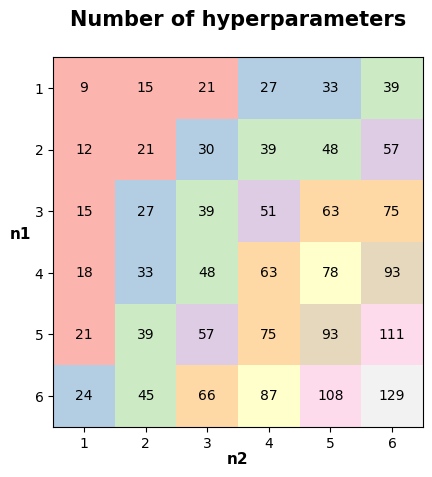

In [7]:
def count_hps(n1, n2, D=3):
    '''
    Count the number of hyperparameters for the sparse-discovering kernel
    combined with a periodic kernel.
    Parameters:
    ----------
    n1: int
        "hyper-hyperparameter" for the sparse-discovering kernel, is the n1 in formula (10) of the considered paper.
    n2: int
        "hyper-hyperparameter" for the sparse-discovering kernel, is the n2 in formula (10) of the considered paper.
    D: int
        dimension of the input space, default (for our case) is 3.        
    '''
    return D*n1*n2 + 3*n2 + 3

n_to_show = 6
matrix = np.zeros((n_to_show, n_to_show))
for i in range(n_to_show):
    for j in range(n_to_show):
        matrix[i, j] = count_hps(i+1, j+1, D= 3)

# make the plot: 
# plt.imshow(matrix, cmap='coolwarm')
# plt.imshow(matrix, cmap='Wistia')
plt.imshow(matrix, cmap='Pastel1')
# Add text annotations
for i in range(n_to_show):
    for j in range(n_to_show):
        plt.text(j, i, int(matrix[i, j]), ha='center', va='center', color='black')
# Set ticks for x and y axes
plt.xticks(np.arange(n_to_show), np.arange(1, n_to_show+1))
plt.yticks(np.arange(n_to_show), np.arange(1, n_to_show+1))

plt.xlabel('n2', rotation=0, labelpad=1, fontsize=11, fontweight='bold')
plt.ylabel('n1', rotation=0, labelpad=10, fontsize=11, fontweight='bold')
plt.title('Number of hyperparameters\n', fontsize=15, fontweight='bold')
plt.show()


#### 2. How to use the GP class, default kernel

For now, just to see how the GP class should be used, let's consider the default kernel

In [8]:
# run only once
client = Client()

In [9]:
default_gp = GP(INPUT_SPACE_DIM, x_data, y_data, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)
#default_gp.train()


# ensure that the train actually does something
print(f"hyperparameters before training: {default_gp.get_hyperparameters()}")
untrained_hps = default_gp.get_hyperparameters()
untrained_ll = default_gp.log_likelihood()
default_gp.train()
print(f"hyperparameters after training: {default_gp.get_hyperparameters()}")
trained_hps = default_gp.get_hyperparameters()
print(f"Log-likelichood before training: {untrained_ll}, after training: {default_gp.log_likelihood()}")


hyperparameters before training: [ 286.65576872  658.82769332 1355.01613013  194.80856502]
hyperparameters after training: [572.18634357  15.96732261 772.17350553 520.68909229]
Log-likelichood before training: -7361.032689874151, after training: -2658.2034132773956


In [10]:
# Note that once we have trained the model once, we can re-define a new GP object with the same data and hyperparameters.
# In this way we can split the training and prediction steps, and we can avoid to re-train the model every time we want to make a prediction.

new_gp = GP(INPUT_SPACE_DIM, x_data, y_data, init_hyperparameters=trained_hps, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)
print(f"New-defined GP hyperparameters: {new_gp.get_hyperparameters()}")
print(f"New-defined GP log-likelihood: {new_gp.log_likelihood()}")

New-defined GP hyperparameters: [572.18634357  15.96732261 772.17350553 520.68909229]
New-defined GP log-likelihood: -2687.5931352734133


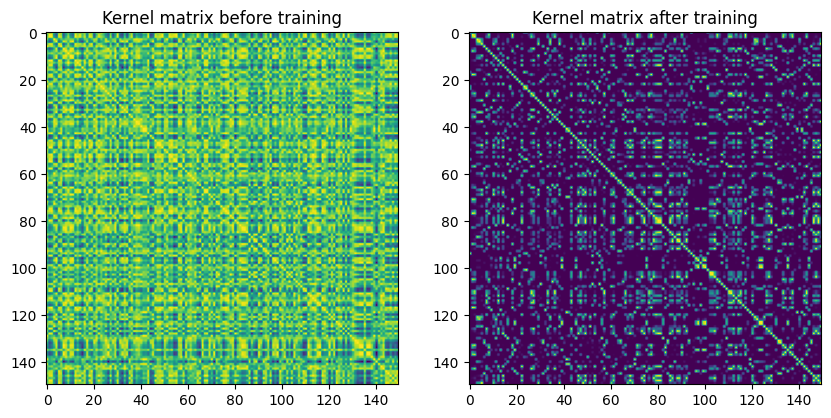

In [11]:
# see the matrix of the kernel
# Remark: by default is saved as a sparse matrix, we need a dense-form to plot it

old_GP = GP(INPUT_SPACE_DIM, x_data, y_data, init_hyperparameters=untrained_hps, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)
trained = GP(INPUT_SPACE_DIM, x_data, y_data, init_hyperparameters=trained_hps, gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)
old_K = old_GP.K.toarray()
train_k = trained.K.toarray()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(old_K)
ax[0].set_title('Kernel matrix before training')
ax[1].imshow(train_k)
ax[1].set_title('Kernel matrix after training')
plt.show()

#### 3. Use the GP class, but with our custom defined kernel

First of all, a brief recap of the kernel we want to use. 

- The first and main component is the $k_s$ kernel, which is a sparse-discovering kernel. It is defined as follows:

$$
 k_s(\mathbf{x}_1, \mathbf{x}_2) = \tilde{k}( \mathbf{x}_1, \mathbf{x}_2 ) \sum_{i}^{n_1}{f_i(\mathbf{x}_1)f_i(\mathbf{x}_2)} 
$$

Where:

$$
f_i(\mathbf{x}) = \sum_{j =1}^{n_2} a_{ij} \exp\left[ \frac{-\beta_{ij}}{1-\frac{\lVert \mathbf{x}-\mathbf{x_0}^{ij} \rVert^2_2}{r_{ij}^2}} \right]\chi\left( r_{ij} < \lVert \mathbf{x} - \mathbf{x}_0^{ij} \rVert_2 \right)
$$

and 

$$
\tilde{k}(\mathbf{x}_1, \mathbf{x}_2) = \begin{cases}
\frac{\sqrt{2}}{\sqrt[3]{\pi}} \left(  3\left(\frac{d}{r}\right)^2 \log{\left( \frac{\frac{d}{r}}{1+\sqrt{1-\left(\frac{d}{r}\right)^2}}   \right)}   +\left(2\left(\frac{d}{r}\right)^2 + 1\right) \sqrt{1-\left(\frac{d}{r}\right)^2}  \right)  & \text{if } d < r \\
0 & \text{otherwise}
\end{cases}
$$

Secondly, our interest is to combine this kernel with a periodic kernel, which is defined as:

$$
k_p(\mathbf{x}_1, \mathbf{x}_2) = \sigma^2 \exp\left( -\frac{2\sin^2(\pi \lVert \mathbf{x}_1 - \mathbf{x}_2 \rVert_2 / p)}{l^2} \right)
$$

The final kernel is then:

$$
k_{\text{custom}}(\mathbf{x}_1, \mathbf{x}_2) = k_s(\mathbf{x}_1, \mathbf{x}_2) \cdot k_p(\mathbf{x}_1, \mathbf{x}_2)
$$

In [12]:
# Reading the docs, the function passed as input to the GP class should be: 

 # gp_kernel_function : Callable, optional
 #        A symmetric positive semi-definite covariance function (a kernel)
 #        that calculates the covariance between
 #        data points. It is a function of the form k(x1,x2,hyperparameters, obj).
 #        The input x1 is a N1 x D array of positions, x2 is a N2 x D
 #        array of positions, the hyperparameters argument
 #        is a 1d array of length D+1 for the default kernel and of a different
 #        user-defined length for other kernels
 #        obj is an `fvgp.GP` instance. The default is a stationary anisotropic kernel
 #        (`fvgp.GP.default_kernel`) which performs automatic relevance determination (ARD).
 #        The output is a covariance matrix, an N1 x N2 numpy array.
 #        Isac:  In our case N1=N2, hence the output is a square matrix.
 
 # see: https://github.com/lbl-camera/fvGP/blob/master/fvgp/gp.py#L75

In [13]:
def l2_norm(x1, x2):
    '''
    Compute the L2 norm between two vectors. This is the considered distance function for the kernel.
    Parameters:
    ----------
    x1: np.array
        first vector
    x2: np.array
        second vector
    '''
    return np.sqrt(np.sum((x1 - x2)**2))

In [14]:
def custom_kernel(x1, x2, hyperparameters, obj):
    '''
    Custom kernel for the GP class. It is a combination of a sparse-discovering kernel and a periodic kernel.
    Parameters:
    ----------
    x1: np.array
        first vector
    x2: np.array
        second vector
    hyperparameters: np.array
        hyperparameters for the kernel. Should be a (n1*n2*D + 2*n2 + 3) array, with hyperparameters ordered as follows:
            - n1*n2*D  ***: coordinates for the bump functions centers      (x0_ij in the paper)
            - n2  ***: radii for the bump functions                         (r_ij in the paper)
            - n2  ***: amplitudes for the bump functions                    (alpha_ij in the paper)
            - n2  ***: shape parameter for the bump functions               (beta_ij in the paper)
            - 1  ***: threshold for the k_tilde function                    (r in the paper)                       
            - 1  ***: length scale for the K_s                              (novelty respect to the paper: needed for the k_p kernel)
            - 1  ***: period for the periodic kernel K_p                    (novelty respect to the paper: needed for the k_p kernel)
    obj: GP
        GP object
    '''
    # For now, we need to hard-code in the function the values of n1, n2 and D. 
    # Make it parametric requires to re-implement the library!
    n1 = 2
    n2 = 2
    D = INPUT_SPACE_DIM  # 3
    
    ## Extract the hyperparameters ##
    
    centers = hyperparameters[:n1*n2*D].reshape(n1, n2, D)      # Bump functions centers --> n1*n2 values in R^D: [[x0_11, x0_12, x0_13], [x0_21, x0_22, x0_23],...]
    # centers = hyperparameters[:n1*n2*D]                       # Bump functions centers --> n1*n2 values: [x0_11, x0_12, x0_13, x0_21, x0_22, x0_23,...]
    radii = hyperparameters[n1*n2*D:n1*n2*D + n2]
    amplitudes = hyperparameters[n1*n2*D + n2:n1*n2*D + 2*n2]   
    shape_parameters = hyperparameters[n1*n2*D + 2*n2:n1*n2*D + 3*n2]
    
    r = hyperparameters[-3]
    
    length_scale = hyperparameters[-2]
    period = hyperparameters[-1]
    
    ## Compute the K_s kernel ##
    
    def l2_norm(x1, x2):
        '''
        Compute the L2 norm between two vectors. This is the considered distance function for the kernel.
        Parameters:
        ----------
        x1: np.array
            first vector
        x2: np.array
            second vector
        '''
        return np.sqrt(np.sum((x1 - x2)**2))
    
    def f_i(x, i, j):
        '''
        Compute the bump function f_i(x) for the sparse-discovering kernel.
        Parameters:
        ----------
        x: np.array
            input vector
        i: int
            index of the bump function, i in {1, ..., n1}
        j: int
            index of the bump function, j in {1, ..., n2}
        '''
        x0 = centers[i, j]
        r = radii[j]
        a = amplitudes[j]
        beta = shape_parameters[j]
        chi = 0
        if r < l2_norm(x, x0):
            chi = 1
        return a * np.exp(-1*beta/(1 - (l2_norm(x, x0)**2)/r**2)) * chi
    
    def tilde_k(x1, x2, r):
        '''
        Compute the tilde_k kernel for the sparse-discovering kernel.
        Parameters:
        ----------
        x1: np.array
            first vector
        x2: np.array
            second vector
        r: float
            threshold for the k_tilde function
        '''
        d = l2_norm(x1, x2)
        if d == 0:
            d = 1e-10 # avoid log(0)
        if d < r:
            return np.sqrt(2) / (np.pi**(1/3)) * (3 * (d/r)**2 * np.log((d/r) / (1 + np.sqrt(1 - (d/r)**2))) + (2 * (d/r)**2 + 1) * np.sqrt(1 - (d/r)**2))
        return 0
        
    def k_s(x1, x2):
        '''
        Compute the K_s kernel for the sparse-discovering kernel.
        Parameters:
        ----------
        x1: np.array
            first vector
        x2: np.array
            second vector
        '''
        return tilde_k(x1, x2, r) * np.sum([f_i(x1, i, j) * f_i(x2, i, j) for i in range(n1) for j in range(n2)])
    
    ## Compute the K_p kernel ##
    
    def k_p(x1, x2):
        '''
        Compute the K_p kernel for the periodic kernel.
        Parameters:
        ----------
        x1: np.array
            first vector
        x2: np.array
            second vector
        '''
        return np.exp(-2 * np.sin(np.pi * l2_norm(x1, x2) / period)**2 / length_scale**2)
    
    ## Compute the final kernel ##
    
    return k_s(x1, x2) * k_p(x1, x2)        

In [21]:
def custom_kernel_matrix(x_data, x_data1, hyperparameters, obj):
    N = x_data.shape[0]
    K = np.empty([N, N])
    # the matrix is symmetric, so we can compute only the upper triangular part
    for i in range(N):
        for j in range(i, N):
            K[i, j] = custom_kernel(x_data[i], x_data1[j], hyperparameters, obj)
            K[j, i] = K[i, j]
    return K

[[210.90549591   0.           0.         ...   0.           0.
    0.        ]
 [  0.         210.87954448  25.40663625 ...   0.           0.
    0.        ]
 [  0.          25.40663625 210.88198718 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 210.95243089   0.
    0.        ]
 [  0.           0.           0.         ...   0.         210.87661109
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  210.91662664]]


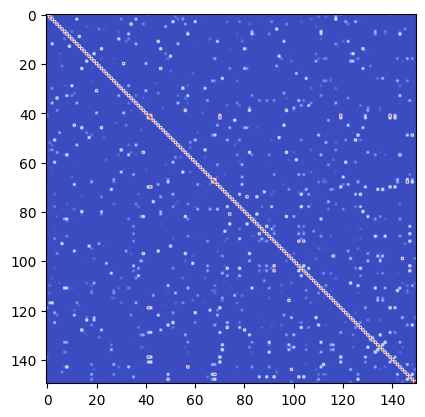

In [22]:
K = custom_kernel_matrix(x_data, x_data, build_hps(2, 2), None)
print(K)
plt.imshow(K, cmap='coolwarm')

In [17]:
# def dummy_gp_noise_fun(x_data, hps, obj):
#     '''
#     Dummy function for the noise variance. It must return a matrix of shape 
#     (x_data.shape[0], x_data.shape[0]) with the noise variance for each pair of points.
#     Parameters:
#     ----------
#     x_data: np.array
#         input data
#     hps: np.array
#         hyperparameters: not used, but keeped for compatibility with the GP class
#     obj: GP
#         GP object
#     '''
#     print('dummy_gp_noise_fun called')
#     print(f"returned shape: {(x_data.shape[0], x_data.shape[0])=}")
#     return np.ones((x_data.shape[0], x_data.shape[0]))

In [18]:
# see if the custom kernel works

# custom_gp = GP(INPUT_SPACE_DIM, x_data, y_data, gp_kernel_function=custom_kernel_matrix, init_hyperparameters=build_hps(2, 2), noise_variances=np.ones(y_data.shape[0]))
custom_gp = GP(INPUT_SPACE_DIM, x_data, y_data, gp_kernel_function=custom_kernel_matrix, init_hyperparameters=build_hps(2, 2),  gp2Scale=True, gp2Scale_dask_client=client, gp2Scale_batch_size=10)

In [19]:
K_before = custom_gp.K.toarray()

start = time.time()
custom_gp.train(hyperparameter_bounds=build_bounds(2, 2))
end = time.time()
print(f"Training time: {end - start}")
K_after = custom_gp.K.toarray()

Training time: 168.52133989334106


Matrix are the same:  False


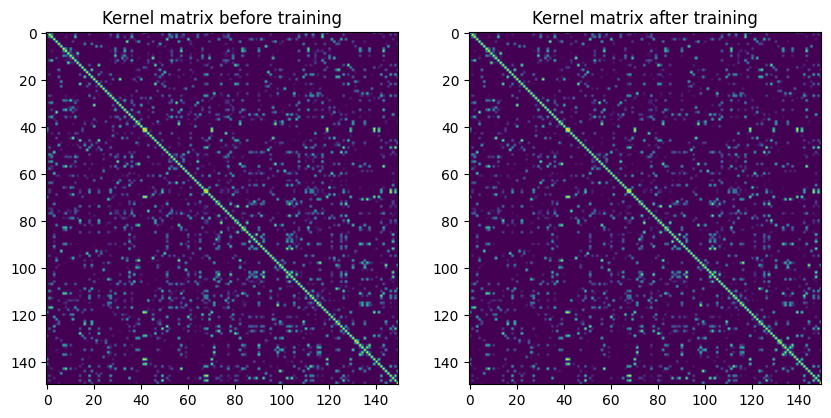

In [20]:
# See if it learned something
print(f"Matrix are the same:  {np.allclose(K_before, K_after)}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(K_before)
ax[0].set_title('Kernel matrix before training')
ax[1].imshow(K_after)
ax[1].set_title('Kernel matrix after training')
plt.show()